In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tf_silent
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer_indlosses import L_BFGS_B

In [3]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [4]:

foam_df = pd.read_excel("/mnt/data_dzne_archiv2/Studien/Deep_Learning_Visualization/temporary_stuff/Jaya_Chandra_Terli/SS-2025/SLB-Project/Navier_Stokes_cylinder2D/data/Re40_Med_10k/foam_re40.xlsx")

# foam_df.head()
foam_df['cx'] = foam_df['cx'].apply(lambda x: x+ 0.5)
foam_df['cy'] = foam_df['cy'].apply(lambda x: x+ 0.5)
# foam_df['U'] = foam_df['U'].apply(lambda x: x[0].split(' '))
# foam_df.head()

# Split U column into u, v (ignore the third value)
foam_df[['u', 'v', '_']] = foam_df['U'].str.extract(r'\(?\s*([-\d.eE]+)\s+([-\d.eE]+)\s+([-\d.eE]+)\s*\)?')
foam_df['u'] = foam_df['u'].astype(float)
foam_df['v'] = foam_df['v'].astype(float)
foam_df['p'] = foam_df['p'].astype(float)

# foam_df.head()
x_of = foam_df['cx'].values
y_of = foam_df['cy'].values
u_of = foam_df['u'].values
v_of = foam_df['v'].values
p_of = foam_df['p'].values

(x_of.dtype, x_of.shape), (y_of.dtype, y_of.shape), (u_of.dtype, u_of.shape), (v_of.dtype, v_of.shape), (p_of.dtype, p_of.shape)

((dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)))

In [5]:
def plot_xy_sel_with_domain(xy_sel, x_ini=0, x_f=2, y_ini=0, y_f=1, circle_center=(0.5, 0.5), circle_radius=0.1, title="xy_sel with Domain"):
    """
    Plot xy_sel points with rectangle domain and inner circle.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, Circle

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(xy_sel[:, 0], xy_sel[:, 1], s=5, c='blue', alpha=0.5, label="Selected Points")
    # Draw rectangle (domain)
    rect = Rectangle((x_ini, y_ini), x_f - x_ini, y_f - y_ini, linewidth=2, edgecolor='black', facecolor='none', label="Domain")
    ax.add_patch(rect)
    # Draw circle (obstacle)
    # circle = Circle(circle_center, circle_radius, color='gray', fill=False, linestyle='--', linewidth=2, label="Cylinder")
    # ax.add_patch(circle)
    ax.set_xlim(x_ini-0.1, x_f+0.1)
    ax.set_ylim(y_ini-0.1, y_f+0.1)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.show()


# plot_xy_sel_with_domain(xy_sel, title="Selected OpenFoam Points with Domain and Cylinder")

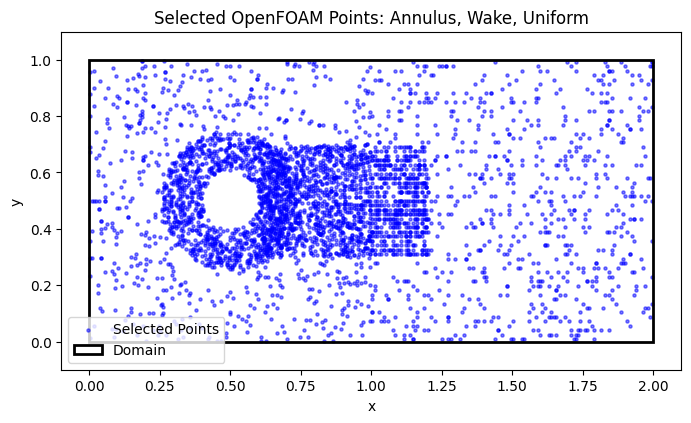

In [6]:
import numpy as np
from scipy.spatial import cKDTree

# Domain/cylinder parameters
Cx, Cy = 0.5, 0.5
a, b = 0.1, 0.1

# 1. Annulus around cylinder (outer radius 0.25)
num_annulus_samples = 1000
theta = np.random.uniform(0, 2*np.pi, num_annulus_samples)
r = np.sqrt(np.random.uniform(1, 6, num_annulus_samples)) * a  # sqrt for uniform area, scale for radius
x_annulus = Cx + r * np.cos(theta)
y_annulus = Cy + r * np.sin(theta)
xyt_annulus = np.stack([x_annulus, y_annulus], axis=1)

# 2. Wake region rectangle
num_strip_samples = 1500
x_strip = np.random.uniform(0.6, 1.2, num_strip_samples)
y_strip = np.random.uniform(0.3, 0.7, num_strip_samples)
xyt_strip = np.stack([x_strip, y_strip], axis=1)

# 3. Uniform points elsewhere (excluding cylinder, annulus, and wake)

num_uniform = 4000 - num_annulus_samples - num_strip_samples
# xy_uniform = uniform_points_in_domain_exclusive(num_uniform)

def uniform_points_in_domain(n_points, x_ini=0, x_f=2, y_ini=0, y_f=1, circle_center=(0.5, 0.5), circle_radius=0.1):
    points = []
    while len(points) < n_points:
        x = np.random.uniform(x_ini, x_f)
        y = np.random.uniform(y_ini, y_f)
        if ((x - circle_center[0])**2 + (y - circle_center[1])**2) >= circle_radius**2:
            points.append([x, y])
    return np.array(points)

xy_uniform = uniform_points_in_domain(num_uniform)

# Combine all regions
xyt_roi = np.concatenate([xyt_annulus, xyt_strip, xy_uniform], axis=0)

mask_outside_cylinder = ((xyt_roi[:, 0] - Cx)**2 / a**2 + (xyt_roi[:, 1] - Cy)**2 / b**2) >= 1
xyt_roi = xyt_roi[mask_outside_cylinder]

# KDTree selection from OpenFOAM points
coords_of = np.stack((x_of, y_of), axis=-1)
tree = cKDTree(coords_of)
_, indices = tree.query(xyt_roi, k=1)
x_sel = x_of[indices]
y_sel = y_of[indices]
u_sel = u_of[indices]
v_sel = v_of[indices]
p_sel = p_of[indices]
xy_sel = np.stack((x_sel, y_sel), axis=-1)

# Plot to check
plot_xy_sel_with_domain(xy_sel, title="Selected OpenFOAM Points: Annulus, Wake, Uniform")

In [7]:
uv_sel = np.stack((u_sel, v_sel, p_sel), axis=-1)
uv_sel.shape, xy_sel.shape

((4000, 3), (4000, 2))

In [8]:
# if __name__ == '__main__':
"""
Test the physics informed neural network (PINN) model
for the cavity flow governed by the steady Navier-Stokes equation.
"""

# number of training samples
num_train_samples = 4000
# number of test samples
num_test_samples = 200

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
mu = 0.025
# Re = (L*u0*rho)/mu ==> rho/mu = 40

# # build a core network model
# network = Network().build()
# network.summary()
# # build a PINN model
# pinn = PINN(network, rho=rho, mu=mu).build()


In [9]:

# Domain and circle data
x_f =2
x_ini=0
y_f=1
y_ini=0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1


In [10]:

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# create training input
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

corner_buffer = 0.05
max_attempts = 100

for i in range(num_train_samples):
    attempts = 0
    while True:
        inside_cylinder = (xyt_eqn[i, 0] - Cx)**2 / a**2 + (xyt_eqn[i, 1] - Cy)**2 / b**2 < 1
        near_corner = (
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer)
        )

        if not (inside_cylinder or near_corner):
            break

        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand() + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand() + y_ini

        attempts += 1
        if attempts > max_attempts:
            print(f"Warning: Max attempts reached for sample {i}")
            break  # Accept the current (possibly imperfect) point or skip


In [11]:

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[...,0] = x_ini

x_train = [xy_sel, xyt_eqn, xyt_w1, xyt_w2, xyt_out, xyt_in, xyt_circle]

# create training output
zeros = np.zeros((num_train_samples, 3))
#uv_bnd[..., 0] = -u0 * np.floor(xy_bnd[..., 0]) +1
#ones = np.ones((num_train_samples, 3))
#onze = np.random.rand(num_train_samples, 3)
#onze[...,0] = u0
#onze[...,1] = 0
#onze[...,2] = u0
a = u_0(tf.constant(xyt_in)).numpy()
b = np.zeros((num_train_samples, 1))
onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))

y_train = [uv_sel, zeros, onze, zeros, zeros, zeros, zeros]


In [12]:
print("Training data shapes:")
print("Labels of x: (x_cord, y_cord), y: (u, v, p)")
for x, y in zip(x_train, y_train):
    print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Training data shapes:
Labels of x: (x_cord, y_cord), y: (u, v, p)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)


In [13]:
loss_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [14]:
network = Network().build()
pinn = PINN(network, rho=rho, mu=mu).build()
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train, factr=1e3, m=30, maxls=30, maxiter=30000, loss_weights=loss_weights)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:   9%|▉         | 2756/30000 [11:42<1:55:40,  3.93iter/s, loss=0.107]


In [15]:
import json

network.save("losswght_trails/model_constant_loss_weights.keras")

with open("losswght_trails/loss_constant_lossweights.json", 'w') as f:
    json.dump(lbfgs.loss_history, f)

loaded_pinn = tf.keras.models.load_model("losswght_trails/model_constant_loss_weights.keras")

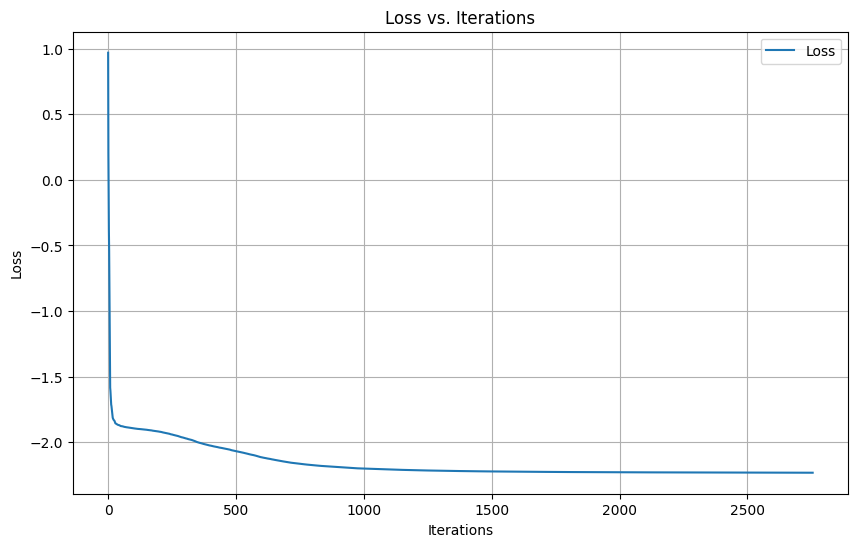

In [16]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(lbfgs.loss_history)), np.log(lbfgs.loss_history), label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid()
# plt.savefig("loss_vs_iterations_re40e4_of_wl10cyl_losstrail.png", dpi=300, bbox_inches='tight')
plt.show()

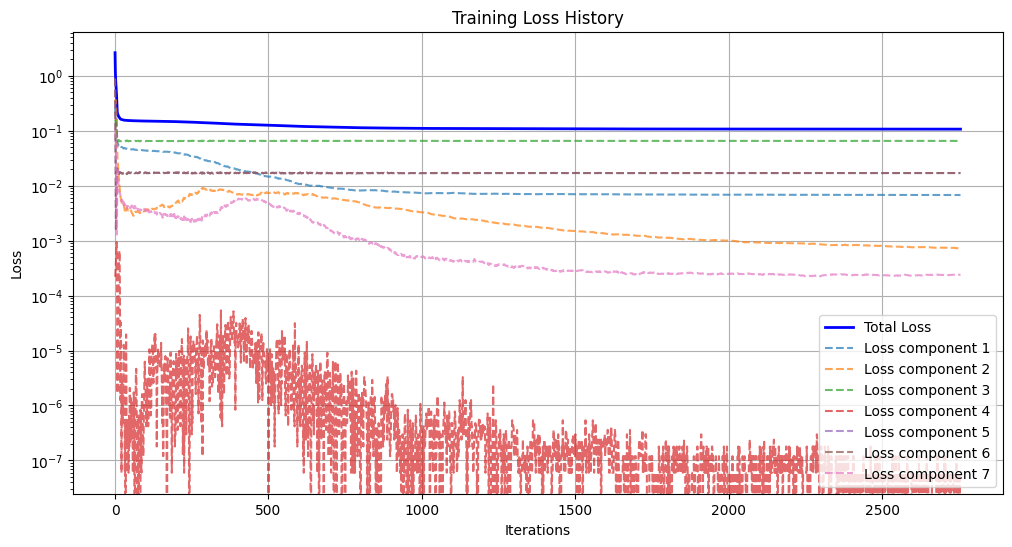

In [17]:
loss_history = lbfgs.loss_history
individual_loss_history = np.array(lbfgs.individual_loss_history)

plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Total Loss', color='blue', linewidth=2)
for i in range(individual_loss_history.shape[1]):
    plt.plot(individual_loss_history[:, i], label=f'Loss component {i+1}', linestyle='--', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss History')
plt.legend()
plt.grid()
plt.show()

In [18]:
def plot_profiles(x, y, u, v, cross_sections, save_csv=False, prefix="u10", location="data/pinn_profiles/"):
    """
    Plot velocity profiles (u, v) along specified cross-sections and optionally save u profiles to CSV.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
        save_csv: If True, save u profiles to CSV files.
        prefix: Prefix for CSV filenames.
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: y as 'x', u as 'u'
                df = pd.DataFrame({'x': y[:, idx], 'u': u[:, idx]})
                filename = f"{prefix}_{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: x as 'x', u as 'u'
                df = pd.DataFrame({'x': x[idx, :], 'u': u[idx, :]})
                filename = f"{prefix}_y{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)

In [20]:

# create meshgrid coordinates (x, y) for test plots    
# from utils import contour_neu as contour
x = np.linspace(x_ini, x_f, 400)
y = np.linspace(y_ini, y_f, 400)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
# predict (psi, p)
# u_v_p = network.predict(xy, batch_size=len(xy))
u_v_p = network.predict(xy, batch_size=len(xy))
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)

1/1 [==============================] - 0s 135ms/step


In [21]:
u.shape, v.shape, p.shape, x.shape, y.shape

((400, 400), (400, 400), (400, 400), (400, 400), (400, 400))

In [22]:
def contour(x, y, z, title, levels=200):
    """
    Contour plot.
    Args:
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
        circle_center: (x, y) center of the circle.
        circle_radius: radius of the circle.
    """
    circle_center = (0.5, 0.5)
    circle_radius = 0.1
    vmin = np.min(z)
    vmax = np.max(z)
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    ax = plt.gca()
    ax.set_aspect('equal')
    circle = plt.Circle(circle_center, circle_radius, fc='black', zorder=10)
    ax.add_patch(circle)
    plt.title(title, fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

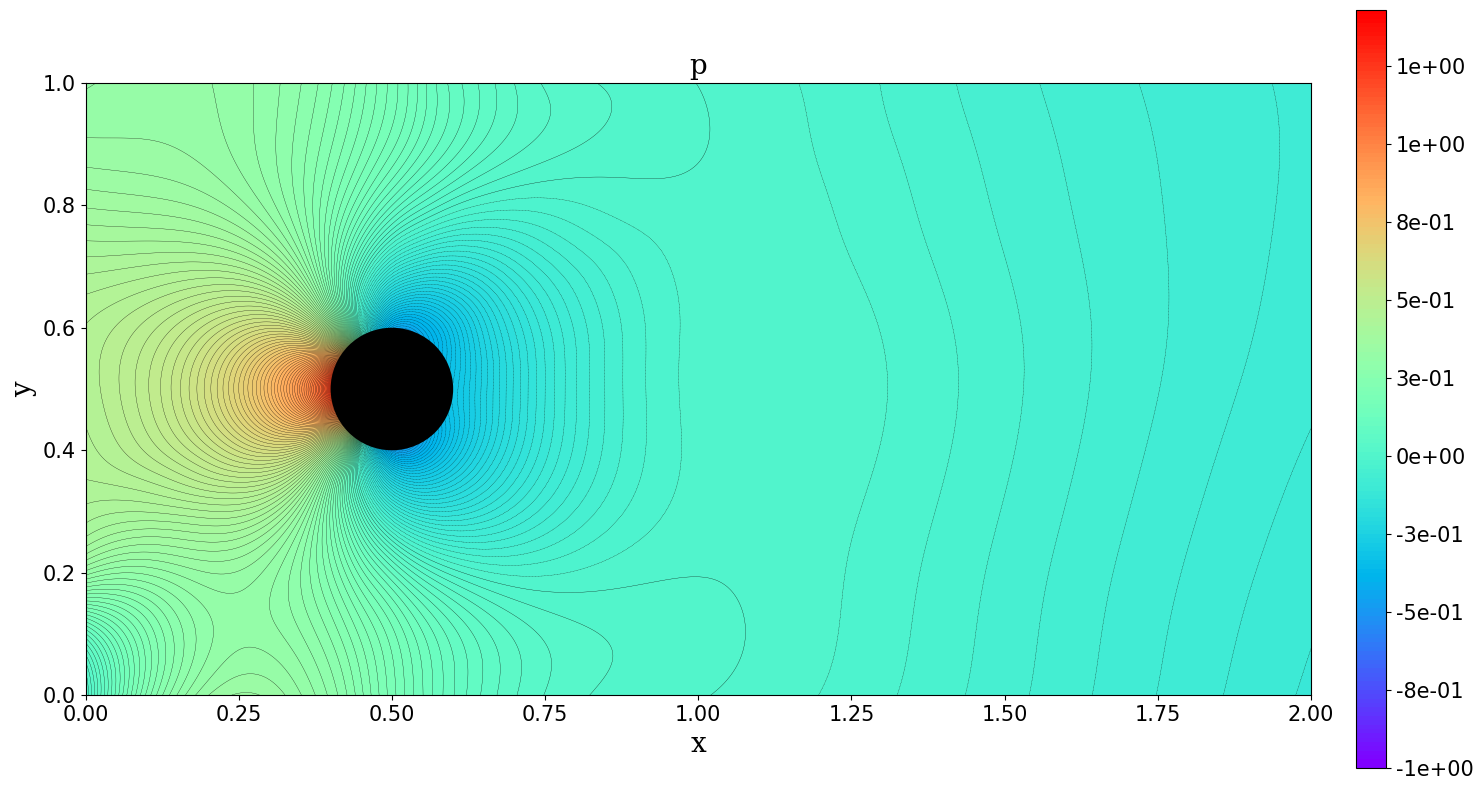

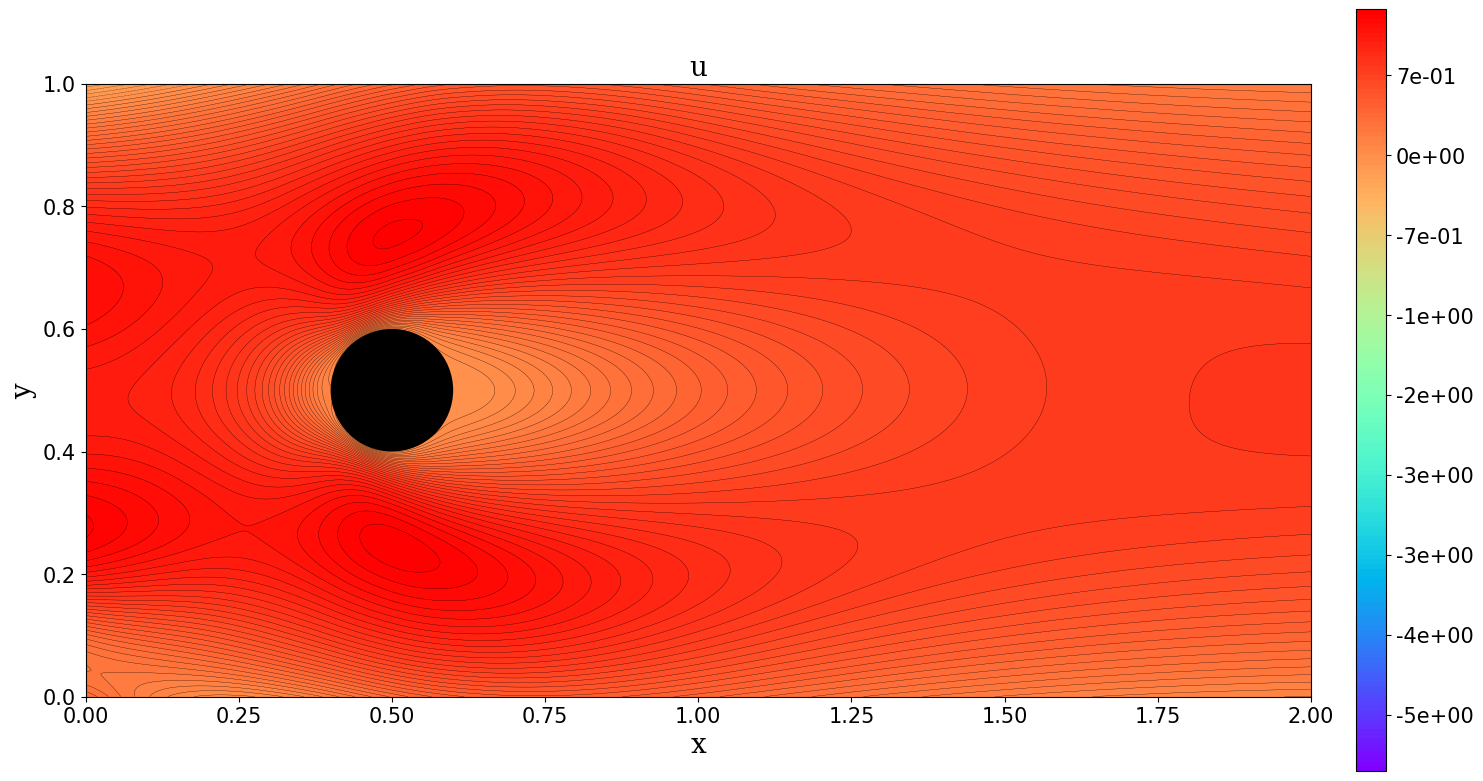

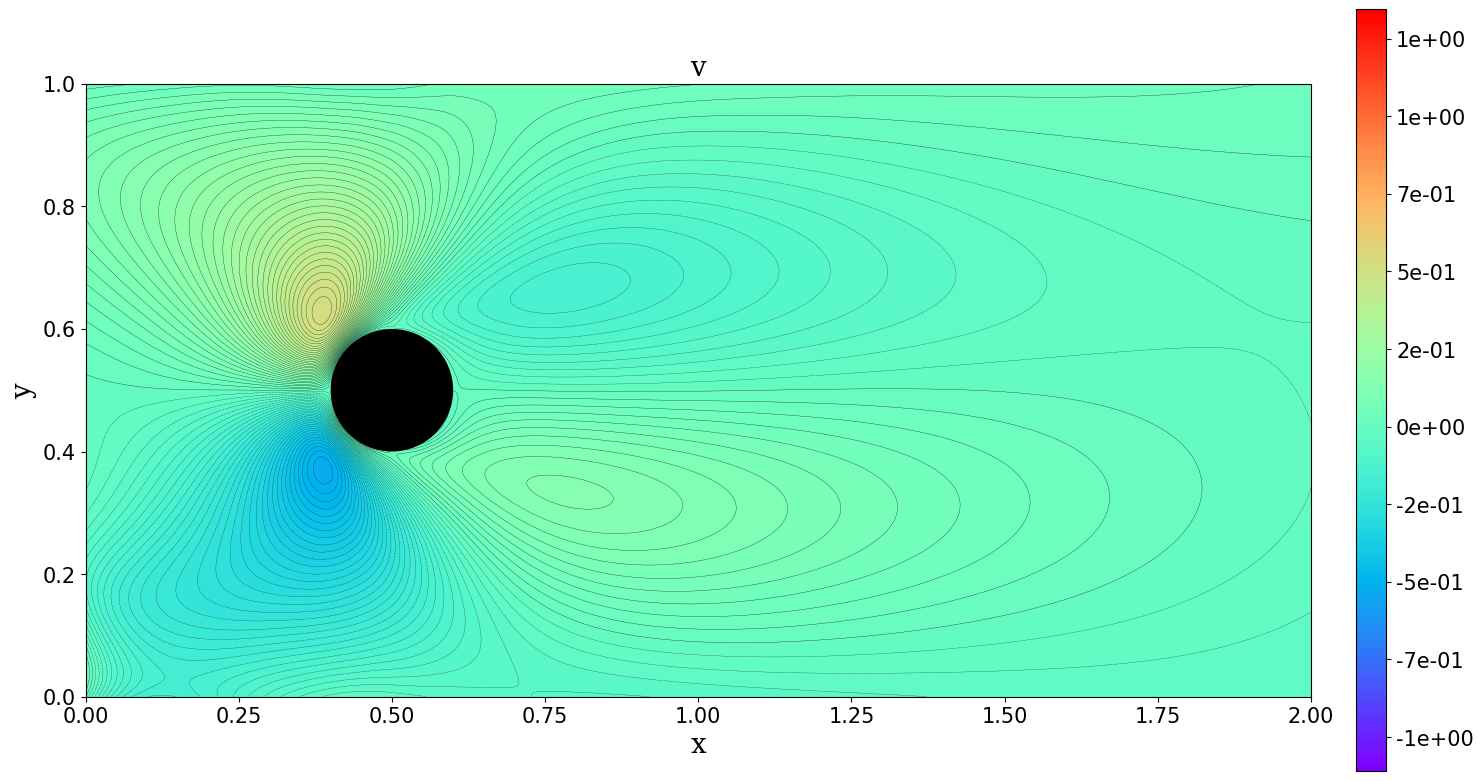

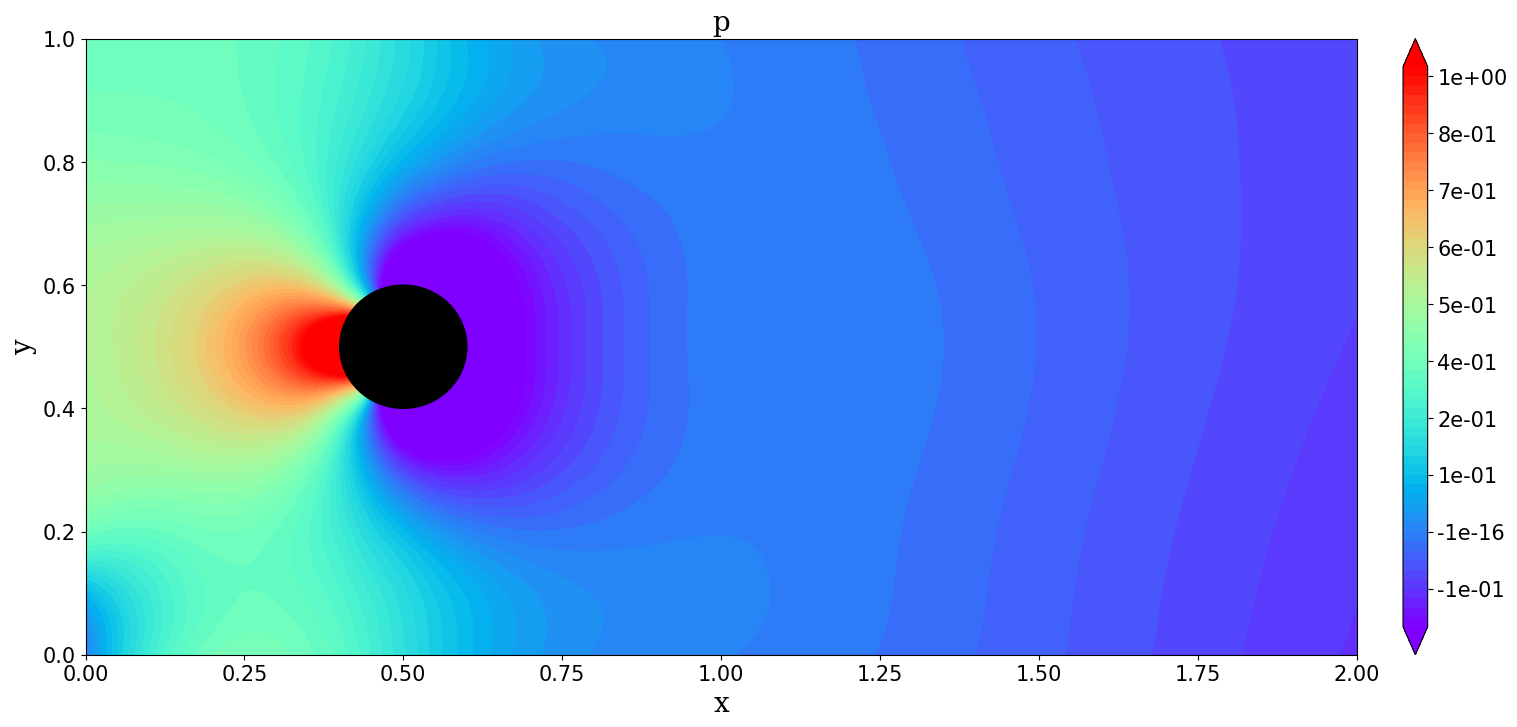

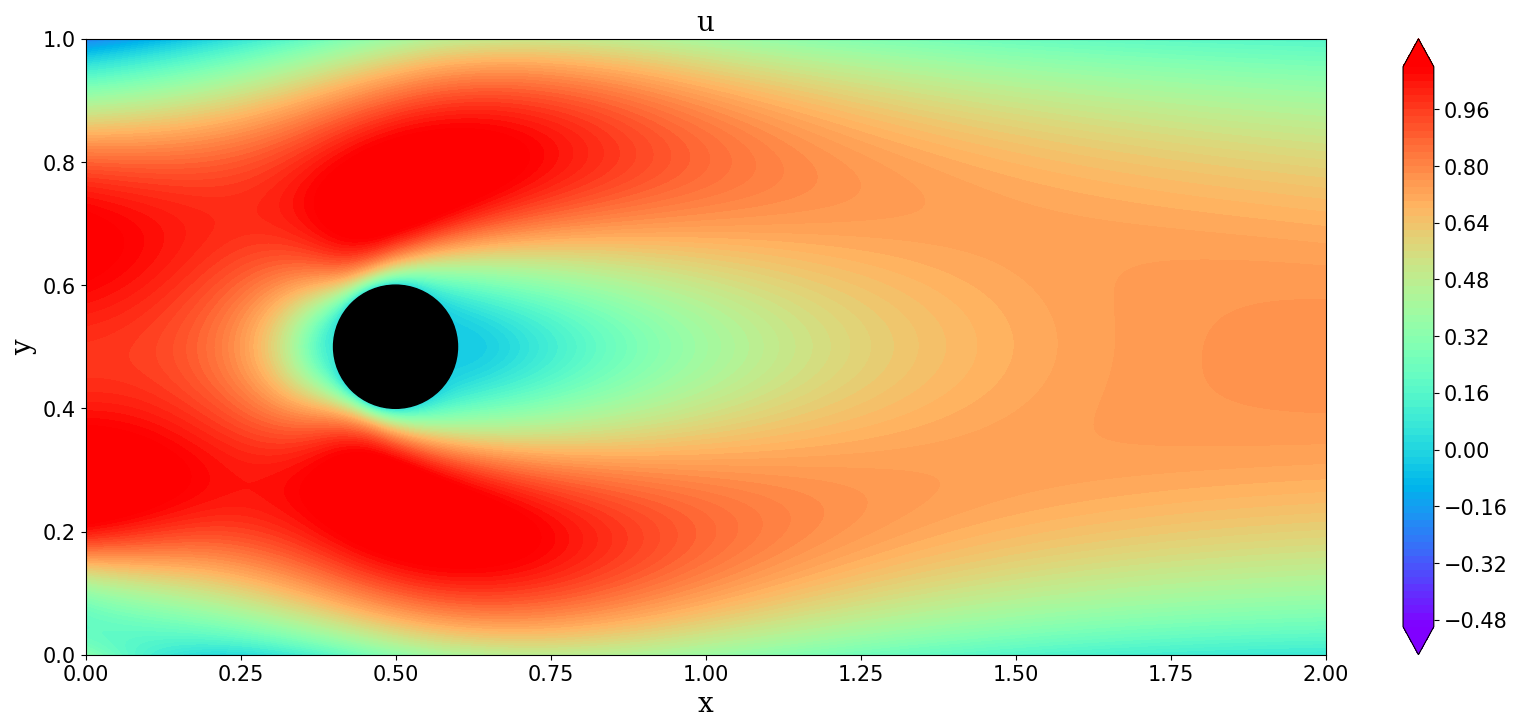

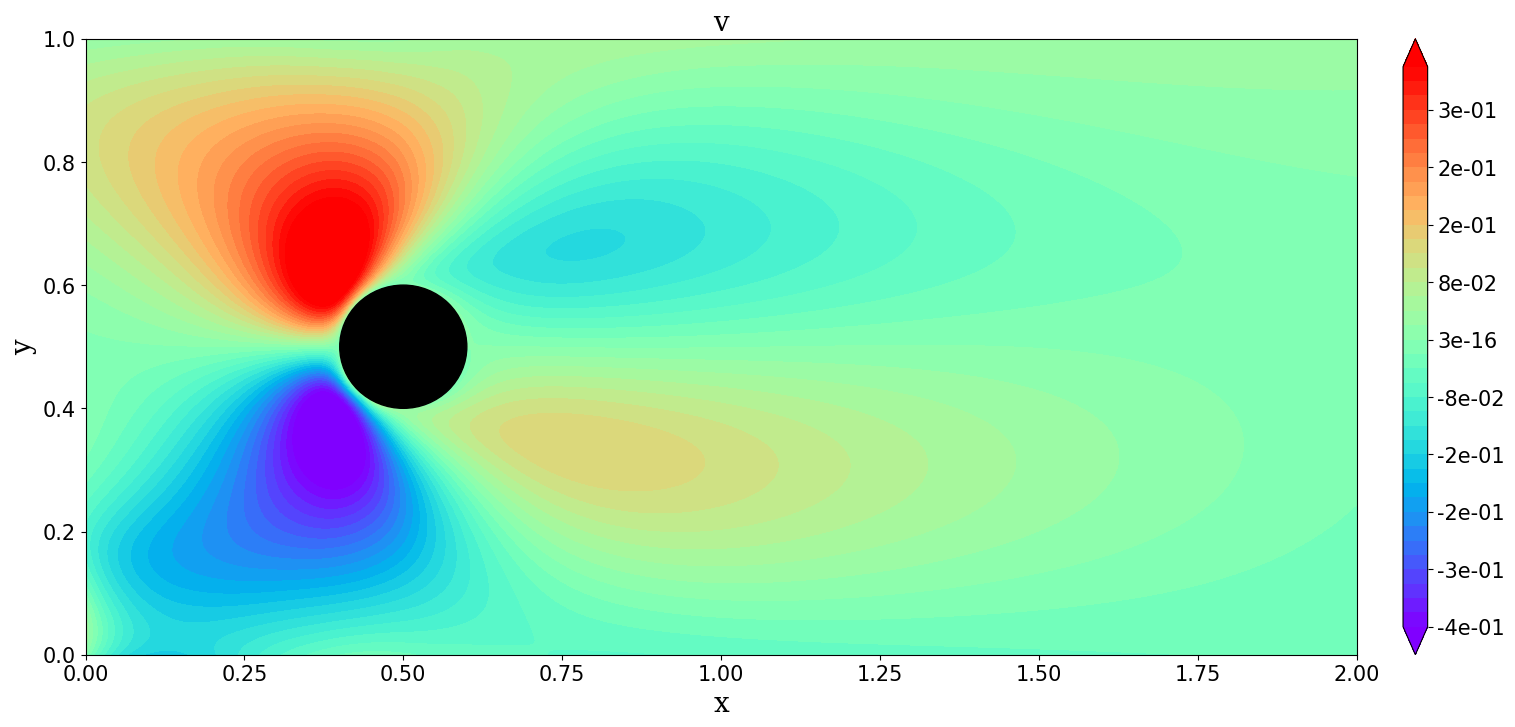

In [23]:

# plot test results
fig = plt.figure(figsize=(16, 8))
contour(x, y, p, 'p')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, u, 'u')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, v, 'v')
plt.tight_layout()
plt.show()


###########################
from matplotlib.patches import Circle
font1 = {'family':'serif','size':20}

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("p", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, )
plt.title("u", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("v", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

############################ 


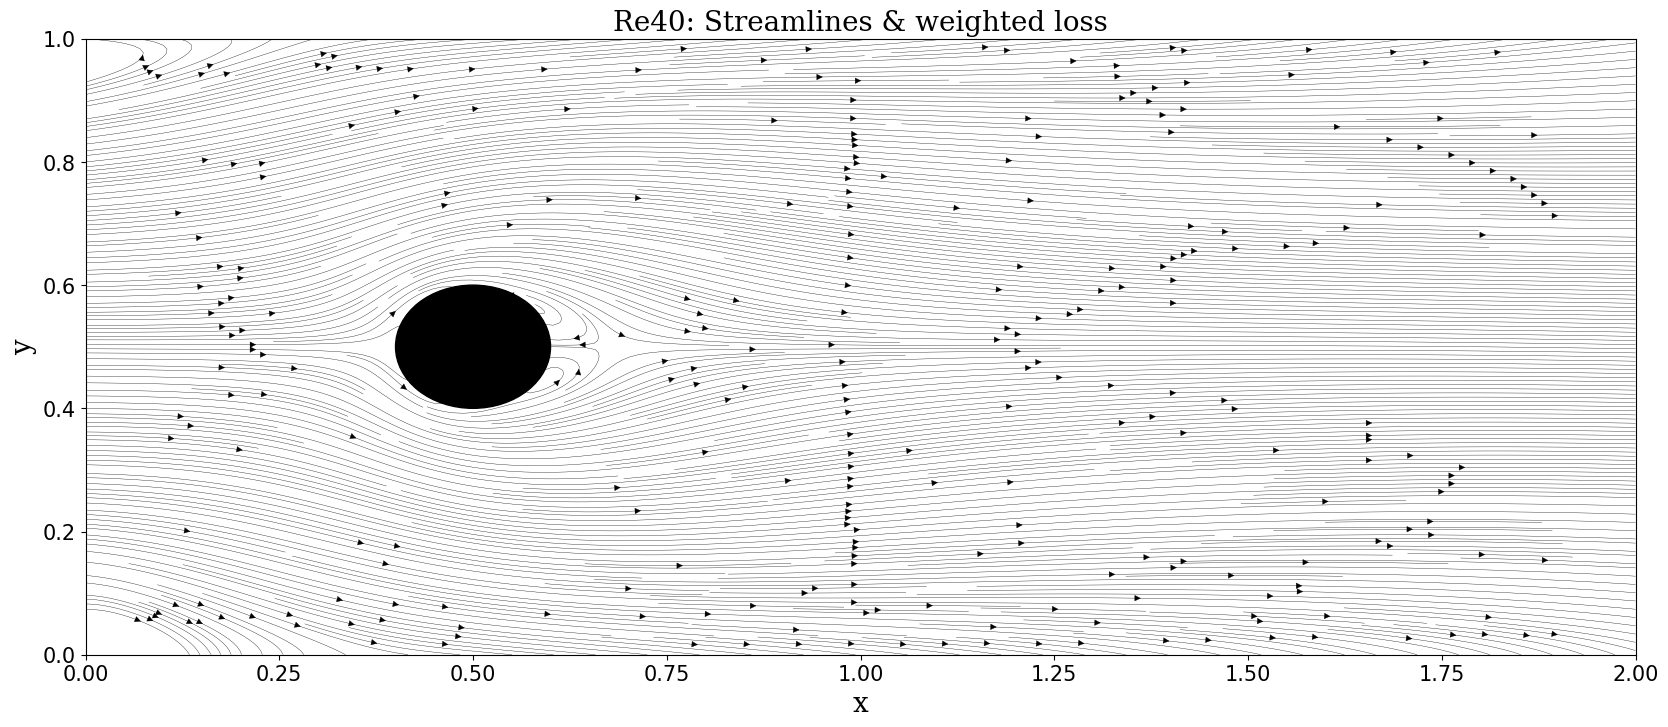

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
# Contourf for pressure (or any scalar field)
# cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
# cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=5, linewidth=0.25)
# Add cylinder
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("Re40: Streamlines & weighted loss", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
# cbar.ax.tick_params(labelsize=15)
# plt.savefig('u_streamlines_Re40_of_roie5_wl10cyl.png', dpi=300)
plt.show()

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=5, linewidth=0.25)
# Add cylinder
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("Re40: Streamlines & weighted loss - Cylinder wall", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.savefig('u_streamlines_Re40_of_roie5_wl10cyl.png', dpi=300)
plt.show()

In [ ]:
# Plot velocity profiles along specified cross-sections
import pandas as pd
cross_sections = [
    ('x', 0.30),
    ('x', 0.35),
    ('x', 0.40),
    ('x', 0.45),
    ('x', 0.50),
    ('x', 0.55),
    ('x', 0.60),
    ('x', 0.65),
    ('x', 0.70),
    ('x', 0.75),
]
plot_profiles(x, y, u, v, cross_sections, save_csv=False, prefix="u40_ofwl_roie5", location="../../data/pinn_profiles/")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="Velocity Profile Comparison"):
    """
    Plot and compare two velocity profiles along the same cross-section.
    Args:
        y_pinn: y-coordinates for PINN data.
        u_pinn: velocity values for PINN data.
        y_ref: y-coordinates for reference data (e.g., OpenFOAM).
        u_ref: velocity values for reference data.
        label_pinn: label for PINN data.
        label_ref: label for reference data.
        title: plot title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(y_pinn, u_pinn, label=label_pinn, color='blue')
    plt.plot(y_ref, u_ref, label=label_ref, color='orange')
    plt.xlabel('y (arc length)')
    plt.ylabel('u (velocity x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# List of cross-sections of interest
cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    # Load OpenFOAM reference data for this cross-section
    # Assumes file naming: data/Re10_cs/Re10_coarse_{x_target}.csv
    fname = f"../../data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        plot_profile_comparison(
            y_pinn, u_pinn, y_ref, u_ref,
            label_pinn="PINN",
            label_ref="OpenFOAM",
            title=f"RE:40, u Profile at x={x_target}"
        )
    except FileNotFoundError:
        print(f"Reference file not found: {fname}")

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

# y_pinn, u_pinn: PINN y and u values at x=0.75
# y_ref, u_ref: OpenFOAM y and u values at x=0.75

# Interpolate PINN profile onto OpenFOAM's y-coordinates
u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
u_pinn_on_ref = u_pinn_interp(y_ref)

# Compute errors
mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

In [ ]:
lbfgs.model.summary()

In [ ]:
from tensorflow.keras.models import load_model
from layer import GradientLayer

loaded_pinn = load_model("pinn_dummysave.h5", custom_objects={'GradientLayer': GradientLayer})


In [ ]:
# def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config